In [ ]:
!pip install transformers scikit-learn pandas nltk


In [ ]:
import pandas as pd

# Load your CSV file
file_path = '/content/updated_duplicated_spam_dataset (1) (1).xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Check the first few rows of the dataset
print(df.head())


    v1                                                 v2 language     source
0  ham          जोस पूछते हैं कि क्या आप मिलना चाहते हैं?    Hindi     Google
1  ham  ఆయన అక్కడే ఉన్నారు. మీరు అతడికి ఫోన్ చేసి కలుస...   Telugu  Microsoft
2  ham  ఉపాధ్యాయుడి కంటే జీవితం చాలా కఠినమైనది ... Bco...   Telugu     Google
3  ham  बहुत खूब। आप ठीक कह रहे हैं! मुझे ऐसा करने का ...    Hindi     Google
4  ham               आप अपनी बाइक की सवारी कब कर रहे हैं?    Hindi     Google


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load your Excel file (adjust the path as needed)
file_path = '/content/updated_duplicated_spam_dataset (1) (1).xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Preprocessing function
def preprocess_text(text, language='english'):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Lowercase to handle case insensitivity

    # Use stopwords for the specific language
    stop_words = set(stopwords.words(language))

    # Remove stopwords, punctuation, and non-alphabetic words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing to the 'v2' column (text column)
df['processed_text'] = df['v2'].apply(preprocess_text)

# Check the result
print(df[['v1', 'v2', 'processed_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


    v1                                                 v2  \
0  ham          जोस पूछते हैं कि क्या आप मिलना चाहते हैं?   
1  ham  ఆయన అక్కడే ఉన్నారు. మీరు అతడికి ఫోన్ చేసి కలుస...   
2  ham  ఉపాధ్యాయుడి కంటే జీవితం చాలా కఠినమైనది ... Bco...   
3  ham  बहुत खूब। आप ठीक कह रहे हैं! मुझे ऐसा करने का ...   
4  ham               आप अपनी बाइक की सवारी कब कर रहे हैं?   

                          processed_text  
0                                     आप  
1                                    ఆయన  
2                           bcoz amp amp  
3  आप कह मतलब एक जब और बदल बदल पर cuz यह  
4                               आप कब कर  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib  # To save the vectorizer for later use

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit and transform the processed text column
X = tfidf_vectorizer.fit_transform(df['processed_text'])

# Save the vectorizer for future use
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Check the shape of the transformed data
print(f"TF-IDF Matrix Shape: {X.shape}")


TF-IDF Matrix Shape: (1969, 447)


In [ ]:
# The target variable 'v1' (ham/spam)
y = df['v1']

# Convert labels into numeric form (Spam = 1, Ham = 0)
y = y.map({'spam': 1, 'ham': 0})


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")


Training Data Shape: (1575, 447)
Test Data Shape: (394, 447)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8629
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       278
           1       0.88      0.62      0.73       116

    accuracy                           0.86       394
   macro avg       0.87      0.79      0.82       394
weighted avg       0.86      0.86      0.86       394



In [ ]:
# Filter data based on source (Google)
google_data = df[df['source'] == 'Google']
X_google = tfidf_vectorizer.transform(google_data['processed_text'])
y_google = google_data['v1'].map({'spam': 1, 'ham': 0})

# Make predictions on the Google dataset
y_google_pred = rf_model.predict(X_google)

# Evaluate the model for Google data
google_accuracy = accuracy_score(y_google, y_google_pred)
print(f'Accuracy for Google data: {google_accuracy:.4f}')

# Filter data based on source (Microsoft)
microsoft_data = df[df['source'] == 'Microsoft']
X_microsoft = tfidf_vectorizer.transform(microsoft_data['processed_text'])
y_microsoft = microsoft_data['v1'].map({'spam': 1, 'ham': 0})

# Make predictions on the Microsoft dataset
y_microsoft_pred = rf_model.predict(X_microsoft)

# Evaluate the model for Microsoft data
microsoft_accuracy = accuracy_score(y_microsoft, y_microsoft_pred)
print(f'Accuracy for Microsoft data: {microsoft_accuracy:.4f}')


Accuracy for Google data: 0.9177
Accuracy for Microsoft data: 0.8900


In [ ]:
# Group by 'source' (Google/Microsoft) and check accuracy separately
for source in df['source'].unique():
    print(f"\nEvaluating model on {source} dataset...\n")

    # Select subset based on source
    X_source = X[df['source'] == source]
    y_source = y[df['source'] == source]

    # Predict on this subset
    y_pred_source = rf_model.predict(X_source)

    # Evaluate
    print("Accuracy:", accuracy_score(y_source, y_pred_source))
    print("Classification Report:\n", classification_report(y_source, y_pred_source))



Evaluating model on Google dataset...

Accuracy: 0.9176706827309237
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       720
           1       0.96      0.73      0.83       276

    accuracy                           0.92       996
   macro avg       0.93      0.86      0.89       996
weighted avg       0.92      0.92      0.91       996


Evaluating model on Microsoft dataset...

Accuracy: 0.8900308324768756
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       695
           1       0.97      0.63      0.77       278

    accuracy                           0.89       973
   macro avg       0.92      0.81      0.85       973
weighted avg       0.90      0.89      0.88       973



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot accuracy comparison
def plot_accuracy_comparison(google_acc, microsoft_acc):
    plt.figure(figsize=(6, 4))
    plt.bar(['Google', 'Microsoft'], [google_acc, microsoft_acc], color=['blue', 'orange'])
    plt.ylabel('Accuracy Score')
    plt.title('Google vs Microsoft Translation Model Accuracy')
    plt.ylim(0, 1)
    plt.show()


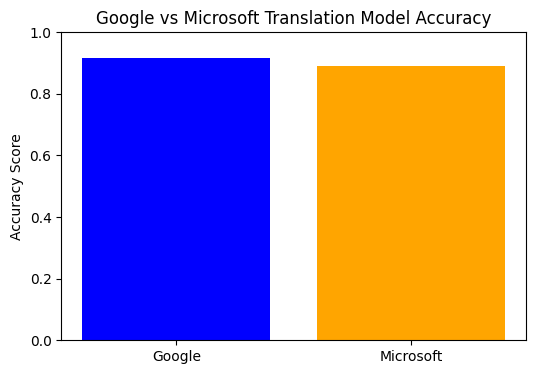

Google Accuracy: 0.92
Microsoft Accuracy: 0.89


In [ ]:
google_mask = df['source'] == 'Google'
microsoft_mask = df['source'] == 'Microsoft'

# Subset Data
X_google, y_google = X[google_mask], y[google_mask]
X_microsoft, y_microsoft = X[microsoft_mask], y[microsoft_mask]

# Predictions
y_pred_google = rf_model.predict(X_google)
y_pred_microsoft = rf_model.predict(X_microsoft)

# Calculate Accuracy
google_accuracy = accuracy_score(y_google, y_pred_google)
microsoft_accuracy = accuracy_score(y_microsoft, y_pred_microsoft)

# Plot Accuracy Comparison
plot_accuracy_comparison(google_accuracy, microsoft_accuracy)

# Print Accuracy Values
print(f"Google Accuracy: {google_accuracy:.2f}")
print(f"Microsoft Accuracy: {microsoft_accuracy:.2f}")


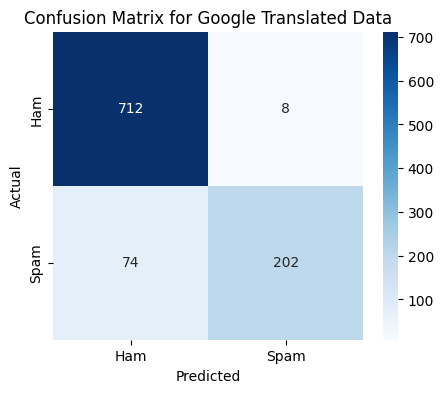

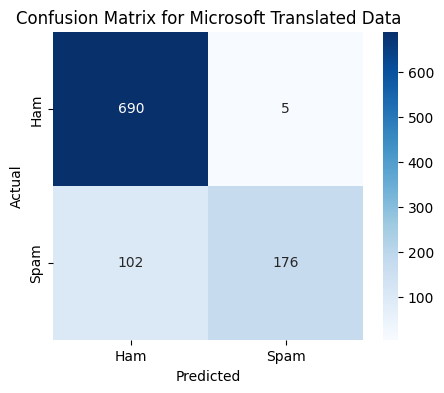

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot for Google
plot_confusion_matrix(y_google, y_pred_google, "Confusion Matrix for Google Translated Data")

# Plot for Microsoft
plot_confusion_matrix(y_microsoft, y_pred_microsoft, "Confusion Matrix for Microsoft Translated Data")


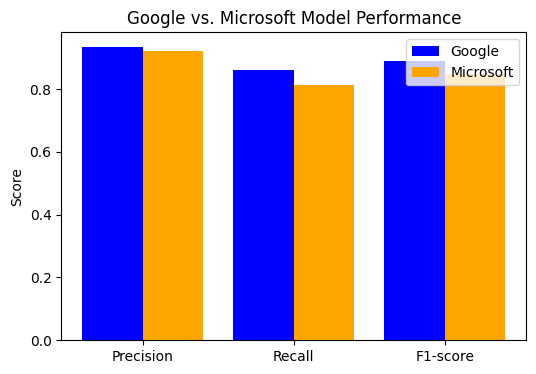

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate scores for Google and Microsoft
metrics = ['Precision', 'Recall', 'F1-score']
google_scores = [
    precision_score(y_google, y_pred_google, average='macro'),
    recall_score(y_google, y_pred_google, average='macro'),
    f1_score(y_google, y_pred_google, average='macro')
]
microsoft_scores = [
    precision_score(y_microsoft, y_pred_microsoft, average='macro'),
    recall_score(y_microsoft, y_pred_microsoft, average='macro'),
    f1_score(y_microsoft, y_pred_microsoft, average='macro')
]

# Plot Precision, Recall, and F1-score
plt.figure(figsize=(6, 4))
x = range(len(metrics))
plt.bar(x, google_scores, width=0.4, label="Google", color='blue')
plt.bar([i + 0.4 for i in x], microsoft_scores, width=0.4, label="Microsoft", color='orange')
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Google vs. Microsoft Model Performance")
plt.legend()
plt.show()


In [ ]:
import nltk

# Download the punkt_tab resource
nltk.download('punkt_tab')

# Now retry running your previous code
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')

# Load your Excel file (adjust the path as needed)
file_path = '/content/updated_duplicated_spam_dataset (1) (1).xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Preprocess function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Convert to lowercase
    return ' '.join(tokens)

# Apply preprocessing to 'v2' column (text column)
df['processed_text'] = df['v2'].apply(preprocess_text)

# Check the result
print(df[['v1', 'v2', 'processed_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


    v1                                                 v2  \
0  ham          जोस पूछते हैं कि क्या आप मिलना चाहते हैं?   
1  ham  ఆయన అక్కడే ఉన్నారు. మీరు అతడికి ఫోన్ చేసి కలుస...   
2  ham  ఉపాధ్యాయుడి కంటే జీవితం చాలా కఠినమైనది ... Bco...   
3  ham  बहुत खूब। आप ठीक कह रहे हैं! मुझे ऐसा करने का ...   
4  ham               आप अपनी बाइक की सवारी कब कर रहे हैं?   

                          processed_text  
0                                     आप  
1                                    ఆయన  
2                           Bcoz amp amp  
3  आप कह मतलब एक जब और बदल बदल पर cuz यह  
4                               आप कब कर  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit and transform the 'processed_text' column
X = tfidf_vectorizer.fit_transform(df['processed_text'])

# The target variable 'v1' (ham/spam)
y = df['v1']


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8629
              precision    recall  f1-score   support

         ham       0.86      0.96      0.91       278
        spam       0.88      0.62      0.73       116

    accuracy                           0.86       394
   macro avg       0.87      0.79      0.82       394
weighted avg       0.86      0.86      0.86       394

